In [1]:
#!/usr/bin/env python
# coding: utf-8

import sys
import platform
import logging
import trino
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

sys.path.append('..')
from common import db_operations

import trino
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
from datetime import datetime, date, timedelta
from common.db_operations import connect_to_trino, fetch_data_for_day, write_df_to_iceberg

from math import radians, sin, cos, sqrt, atan2

# Configure basic logging for the business logic file
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Print the Python version being used
print(f"Using Python version: {platform.python_version()}")
print(sys.executable)

Using Python version: 3.11.13
/home/notebook/naarni_env/bin/python


In [2]:
def get_battery_data(start_time=None, end_time=None, vehicle_ids=None):
    """
    Fetch battery data from Trino with flexible time filtering.
    Joins are performed in pandas instead of SQL.

    Args:
        start_time: Start time in 'YYYY-MM-DD HH:MM:SS' format (optional)
        end_time: End time in 'YYYY-MM-DD HH:MM:SS' format (optional)
        vehicle_ids: List of vehicle IDs to filter (optional)

    Returns:
        DataFrame with battery data
    """
    # Set default vehicle IDs if not provided
    if vehicle_ids is None:
        vehicle_ids = ['3','6','7','9','16', '18','19']

    # Format vehicle IDs for the query
    vehicle_ids_str = "', '".join(vehicle_ids)

    # Build time filter conditions
    time_filter = ""

    if start_time and end_time:
        # Convert string times to datetime objects
        start_dt = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
        end_dt = datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S')

        # Format for the query
        time_filter = f"""
        AND timestamp >= CAST('{start_time}' AS TIMESTAMP) AT TIME ZONE 'Asia/Kolkata'
        AND timestamp < CAST('{end_time}' AS TIMESTAMP) AT TIME ZONE 'Asia/Kolkata'
        """

    # Connect to Trino
    conn = trino.dbapi.connect(
        host="trino",
        port=8080,
        user="admin",
        catalog="adhoc",
        schema="default"
    )

    # Query for cpo100 data
    cpo100_query = f"""
    SELECT 
        id, CAST(timestamp AS TIMESTAMP) AT TIME ZONE 'Asia/Kolkata' as timestamp, dt, 
        date_trunc('minute', CAST(timestamp AS TIMESTAMP) AT TIME ZONE 'Asia/Kolkata') as ts_mins,
        batterycoolingstate, batterycoolanttemperature,
        temperaturedifferencealarm, chargingcurrentalarm, dischargecurrentalarm,
        vehiclereadycondition, gun_connection_status, ignitionstatus,
        vehicle_speed_vcu,gear_position,
        pack1_cellmax_temperature, pack1_maxtemperature_cell_number,
        pack1_cell_min_temperature, pack1_celltemperature_cellnumber
    FROM 
        facts_prod.can_parsed_output_100
    WHERE 
        id IN ('{vehicle_ids_str}')
        {time_filter}
    """

    # Query for can_ac data
    can_ac_query = f"""
    SELECT 
        id, CAST(timestamp AS TIMESTAMP) AT TIME ZONE 'Asia/Kolkata' as timestamp, date,
        date_trunc('minute', CAST(timestamp AS TIMESTAMP) AT TIME ZONE 'Asia/Kolkata') as ts_mins_cac,    
        b2t_tms_control_cmd, b2t_set_water_out_temp, b2t_battery_min_temp, b2t_battery_max_temp,
        tms_working_mode, tms_fault_code, coolant_out_temp, coolant_in_temp,
        (coolant_out_temp - coolant_in_temp) as coolant_temp_diff,
        comp_status,comp_target_hz as comp_target_freq,
        comp_running_frequency as comp_running_freq,
        v2t_vehicle_coolant_low, comp_current
    FROM 
        facts_prod.can_output_ac
    WHERE
        id IN ('{vehicle_ids_str}')
        and b2t_battery_min_temp != -40
        and coolant_in_temp != 0
        {time_filter}
    """

    # Execute queries and fetch data
    cur = conn.cursor()

    # Fetch cpo100 data
    cur.execute(cpo100_query)
    cpo100_columns = [desc[0] for desc in cur.description]
    cpo100_rows = cur.fetchall()
    df_cpo100 = pd.DataFrame(cpo100_rows, columns=cpo100_columns)

    # Fetch can_ac data
    cur.execute(can_ac_query)
    can_ac_columns = [desc[0] for desc in cur.description]
    can_ac_rows = cur.fetchall()
    df_can_ac = pd.DataFrame(can_ac_rows, columns=can_ac_columns)

    # Close connections
    cur.close()
    conn.close()

    # Convert timestamp columns to datetime if they aren't already
    df_cpo100['timestamp'] = pd.to_datetime(df_cpo100['timestamp'])
    df_cpo100['ts_mins'] = pd.to_datetime(df_cpo100['ts_mins'])
    df_can_ac['timestamp'] = pd.to_datetime(df_can_ac['timestamp'])
    df_can_ac['ts_mins_cac'] = pd.to_datetime(df_can_ac['ts_mins_cac'])

    # Add row numbers (equivalent to SQL row_number() window function)
    # For cpo100
    df_cpo100 = df_cpo100.sort_values(['id', 'ts_mins', 'timestamp'])
    df_cpo100['cpo_rn'] = df_cpo100.groupby(['id', 'ts_mins']).cumcount() + 1

    # For can_ac
    df_can_ac = df_can_ac.sort_values(['id', 'ts_mins_cac', 'timestamp'])
    df_can_ac['cac_rn'] = df_can_ac.groupby(['id', 'ts_mins_cac']).cumcount() + 1

    # Perform the join in pandas (equivalent to SQL right join)
    # We'll use a merge operation with the join conditions
    merged_df = pd.merge(
        df_can_ac,
        df_cpo100,
        left_on=['id', 'ts_mins_cac', 'cac_rn'],
        right_on=['id', 'ts_mins', 'cpo_rn'],
        how='left',  # This makes it a right join (keeping all cpo100 records)
        suffixes=('_can_ac','_cpo100')  # Explicitly set suffixes to avoid confusion
    )

    # Debug: Print column names to understand what we have
    logger.info("Columns in merged DataFrame: %s", merged_df.columns.tolist())

    # Select only the columns we need (same as original query)
    # We need to check which columns exist and handle the naming correctly
    result_columns = []

    # Add id column (it will be from cpo100 since we did a right join)
    if 'id' in merged_df.columns:
        result_columns.append('id')
    elif 'id_cpo100' in merged_df.columns:
        result_columns.append('id_cpo100')

    # Add other columns from cpo100
    cpo100_cols = ['dt', 'ignitionstatus', 'vehiclereadycondition', 'gun_connection_status','vehicle_speed_vcu',
                   'gear_position','pack1_cellmax_temperature', 'pack1_cell_min_temperature']

    for col in cpo100_cols:
        if col in merged_df.columns:
            result_columns.append(col)
        elif f'{col}_cpo100' in merged_df.columns:
            result_columns.append(f'{col}_cpo100')

    # Add timestamp (from cpo100)
    if 'timestamp_cpo100' in merged_df.columns:
        result_columns.append('timestamp_cpo100')
    elif 'timestamp' in merged_df.columns:
        result_columns.append('timestamp')

    # Add ts_mins (from cpo100)
    if 'ts_mins_cpo100' in merged_df.columns:
        result_columns.append('ts_mins_cpo100')
    elif 'ts_mins' in merged_df.columns:
        result_columns.append('ts_mins')

    # Add columns from can_ac
    can_ac_cols = ['b2t_tms_control_cmd', 'b2t_set_water_out_temp', 
                  'b2t_battery_min_temp', 'b2t_battery_max_temp', 'tms_working_mode',
                  'coolant_out_temp', 'coolant_in_temp', 'coolant_temp_diff', 'comp_status','tms_fault_code']

    for col in can_ac_cols:
        if col in merged_df.columns:
            result_columns.append(col)
        elif f'{col}_can_ac' in merged_df.columns:
            result_columns.append(f'{col}_can_ac')

    # Create result DataFrame with selected columns
    result_df = merged_df[result_columns].copy()

    # Rename columns to match original query output
    rename_dict = {}
    if 'id_cpo100' in result_df.columns:
        rename_dict['id_cpo100'] = 'id'
    if 'timestamp_cpo100' in result_df.columns:
        rename_dict['timestamp_cpo100'] = 'timestamp'
    if 'ts_mins_cpo100' in result_df.columns:
        rename_dict['ts_mins_cpo100'] = 'ts_mins'

    # Rename any columns with _can_ac suffix
    for col in result_df.columns:
        if col.endswith('_can_ac'):
            rename_dict[col] = col[:-7]  # Remove the '_can_ac' suffix

    result_df = result_df.rename(columns=rename_dict)

    # Sort the result as in the original query
    result_df = result_df.sort_values(['id', 'timestamp'])

    return result_df

In [3]:
def preprocess_data(df):
    """Clean and preprocess the data."""
    logger.info("\nStep 2: Data Preprocessing & Quality Assessment")
    logger.info("=" * 50)

    # Create a copy for cleaning
    clean_df = df.copy()

    # Ensure timestamp columns are datetime
    timestamp_cols = ['timestamp', 'ts_mins']
    for col in timestamp_cols:
        if col in clean_df.columns:
            clean_df[col] = pd.to_datetime(clean_df[col], errors='coerce')

    # Convert numeric columns
    numeric_cols = ['id', 'ignitionstatus', 'vehiclereadycondition', 
                   'gun_connection_status', 'vehicle_speed_vcu', 'gear_position',
                   'pack1_cellmax_temperature', 'pack1_cell_min_temperature',
                   'b2t_set_water_out_temp', 'b2t_battery_min_temp', 
                   'b2t_battery_max_temp', 'coolant_out_temp', 'coolant_in_temp',
                   'coolant_temp_diff']

    for col in numeric_cols:
        if col in clean_df.columns:
            clean_df[col] = pd.to_numeric(clean_df[col], errors='coerce')

    # Handle outliers (-40°C)
    temp_cols = ['pack1_cellmax_temperature', 'pack1_cell_min_temperature',
               'b2t_battery_min_temp', 'b2t_battery_max_temp',
               'coolant_out_temp', 'coolant_in_temp']

    for col in temp_cols:
        if col in clean_df.columns:
            # Replace -40 with NaN (outliers)
            clean_df.loc[clean_df[col] == -40, col] = np.nan

    # Check for missing values
    missing_data = clean_df.isnull().sum()
    missing_percent = (missing_data / len(clean_df)) * 100

    logger.info("\nMissing Values Analysis:")
    missing_df = pd.DataFrame({
        'Column': missing_data.index,
        'Missing Count': missing_data.values,
        'Missing %': missing_percent.values
    })
    display(missing_df[missing_df['Missing Count'] > 0])

    # Remove rows with critical missing values
    critical_cols = ['b2t_tms_control_cmd', 'tms_working_mode', 
                   'b2t_battery_max_temp', 'b2t_battery_min_temp']
    original_count = len(clean_df)
    clean_df.dropna(subset=critical_cols, inplace=True)

    logger.info(f"\nData after cleaning: {clean_df.shape} (removed {original_count - len(clean_df)} rows)")

    return clean_df

In [4]:
def state_transition_analysis(clean_df):
    """Analyze state transitions in the BCS system."""
    logger.info("\nStep 3: State Transition Analysis")
    logger.info("=" * 50)

    # Analyze b2t_tms_control_cmd states
    cmd_counts = clean_df['b2t_tms_control_cmd'].value_counts()
    logger.info("\nb2t_tms_control_cmd Distribution:")
    logger.info(cmd_counts)

    # Analyze tms_working_mode states
    mode_counts = clean_df['tms_working_mode'].value_counts()
    logger.info("\ntms_working_mode Distribution:")
    logger.info(mode_counts)

    # Analyze comp_status
    comp_counts = clean_df['comp_status'].value_counts()
    logger.info("\ncomp_status Distribution:")
    logger.info(comp_counts)

    # Identify state transitions
    clean_df = clean_df.sort_values('timestamp')
    clean_df['cmd_change'] = clean_df['b2t_tms_control_cmd'].ne(
        clean_df['b2t_tms_control_cmd'].shift())
    clean_df['mode_change'] = clean_df['tms_working_mode'].ne(
        clean_df['tms_working_mode'].shift())

    # Get transition points
    cmd_transitions = clean_df[clean_df['cmd_change']]
    mode_transitions = clean_df[clean_df['mode_change']]

    logger.info(f"\nCommand Transitions: {len(cmd_transitions)}")
    logger.info(f"Mode Transitions: {len(mode_transitions)}")

    # Store results
    analysis_results = {}
    analysis_results['state_transitions'] = {
        'cmd_counts': cmd_counts,
        'mode_counts': mode_counts,
        'comp_counts': comp_counts,
        'cmd_transitions': cmd_transitions,
        'mode_transitions': mode_transitions
    }

    return analysis_results, clean_df

In [5]:
def temperature_threshold_analysis(clean_df, analysis_results):
    """Analyze temperature thresholds and system response."""
    logger.info("\nStep 4: Temperature Threshold Analysis")
    logger.info("=" * 50)

    # Filter for active cooling states
    active_cooling = clean_df[
        (clean_df['b2t_tms_control_cmd'] != 'Off') |
        (clean_df['tms_working_mode'] != 'Off')
    ]

    # Analyze charging sessions
    charging_sessions = active_cooling[
        active_cooling['gun_connection_status'] == 1.0
    ]

    # Analyze driving sessions
    driving_sessions = active_cooling[
        active_cooling['vehiclereadycondition'] == 1.0
    ]

    logger.info(f"\nCharging Sessions (gun_connected): {len(charging_sessions)}")
    if len(charging_sessions) > 0:
        logger.info(f"  Battery Temp Range: {charging_sessions['b2t_battery_max_temp'].min():.1f}°C - {charging_sessions['b2t_battery_max_temp'].max():.1f}°C")
        logger.info(f"  Sessions > 30°C: {(charging_sessions['b2t_battery_max_temp'] > 30).sum()} ({(charging_sessions['b2t_battery_max_temp'] > 30).mean()*100:.1f}%)")
        logger.info(f"  Median Activation Temp: {charging_sessions['b2t_battery_max_temp'].median():.1f}°C")

    logger.info(f"\nDriving Sessions (vehicle_ready): {len(driving_sessions)}")
    if len(driving_sessions) > 0:
        logger.info(f"  Battery Temp Range: {driving_sessions['b2t_battery_max_temp'].min():.1f}°C - {driving_sessions['b2t_battery_max_temp'].max():.1f}°C")
        logger.info(f"  Sessions > 35°C: {(driving_sessions['b2t_battery_max_temp'] > 35).sum()} ({(driving_sessions['b2t_battery_max_temp'] > 35).mean()*100:.1f}%)")
        logger.info(f"  Median Activation Temp: {driving_sessions['b2t_battery_max_temp'].median():.1f}°C")

    # Calculate threshold compliance
    threshold_compliance = {
        'charging_expected_30': (charging_sessions['b2t_battery_max_temp'] > 30).mean() if len(charging_sessions) > 0 else 0,
        'driving_expected_35': (driving_sessions['b2t_battery_max_temp'] > 35).mean() if len(driving_sessions) > 0 else 0,
        'charging_median_temp': charging_sessions['b2t_battery_max_temp'].median() if len(charging_sessions) > 0 else 0,
        'driving_median_temp': driving_sessions['b2t_battery_max_temp'].median() if len(driving_sessions) > 0 else 0
    }

    # Store results
    analysis_results['threshold_analysis'] = {
        'charging_sessions': charging_sessions,
        'driving_sessions': driving_sessions,
        'threshold_compliance': threshold_compliance
    }

    return analysis_results

In [6]:
def cooling_effectiveness_analysis(clean_df, analysis_results):
    """Evaluate cooling system effectiveness."""
    logger.info("\nStep 5: Cooling Effectiveness Evaluation")
    logger.info("=" * 50)

    # Calculate coolant temperature differential
    clean_df['coolant_diff'] = clean_df['coolant_in_temp'] - clean_df['coolant_out_temp']

    # Analyze cooling periods
    cooling_active = clean_df[
        (clean_df['b2t_tms_control_cmd'] == 'Charging_Cooling') |
        (clean_df['tms_working_mode'] == 'Charging_Cooling')
    ]

    logger.info(f"Active Cooling Periods: {len(cooling_active)}")

    if len(cooling_active) > 0:
        # Coolant effectiveness
        coolant_stats = cooling_active['coolant_diff'].describe()
        logger.info("\nCoolant Temperature Differential (Inlet - Outlet):")
        logger.info(coolant_stats)

        # Setpoint achievement
        setpoint_achievement = (
            cooling_active['coolant_out_temp'] <= cooling_active['b2t_set_water_out_temp']
        ).mean()
        logger.info(f"\nSetpoint Achievement Rate: {setpoint_achievement*100:.1f}%")

        # Compressor correlation
        comp_on = cooling_active[cooling_active['comp_status'] == 'On']
        logger.info(f"\nCompressor Activation During Cooling: {len(comp_on)} ({len(comp_on)/len(cooling_active)*100:.1f}%)")

        # Temperature change rate
        cooling_active = cooling_active.sort_values(['id', 'timestamp'])
        cooling_active['temp_change'] = cooling_active.groupby('id')['b2t_battery_max_temp'].diff()
        cooling_rate = cooling_active['temp_change'].mean()
        logger.info(f"Average Temperature Change Rate: {cooling_rate:.3f}°C per record")

    # Store results
    analysis_results['cooling_effectiveness'] = {
        'cooling_active': cooling_active,
        'coolant_stats': coolant_stats if len(cooling_active) > 0 else None,
        'setpoint_achievement': setpoint_achievement if len(cooling_active) > 0 else 0,
        'comp_activation_rate': len(comp_on)/len(cooling_active) if len(cooling_active) > 0 else 0,
        'cooling_rate': cooling_rate if len(cooling_active) > 0 else 0
    }

    return analysis_results

In [7]:
def operating_mode_comparison(clean_df, analysis_results):
    """Compare behavior between charging and driving modes."""
    logger.info("\nStep 6: Operating Mode Comparison")
    logger.info("=" * 50)

    # Charging mode analysis
    charging_mode = clean_df[clean_df['gun_connection_status'] == 1.0]
    driving_mode = clean_df[clean_df['vehiclereadycondition'] == 1.0]

    logger.info(f"Charging Mode Records: {len(charging_mode)}")
    logger.info(f"Driving Mode Records: {len(driving_mode)}")

    # Compare temperature statistics
    temp_cols = ['b2t_battery_max_temp', 'b2t_battery_min_temp', 
               'coolant_in_temp', 'coolant_out_temp']

    logger.info("\nTemperature Comparison:")
    for col in temp_cols:
        if col in clean_df.columns:
            charge_mean = charging_mode[col].mean() if len(charging_mode) > 0 else 0
            drive_mean = driving_mode[col].mean() if len(driving_mode) > 0 else 0
            logger.info(f"{col}: Charging={charge_mean:.1f}°C, Driving={drive_mean:.1f}°C")

    # Compare state activation frequency
    charge_active = charging_mode[
        (charging_mode['b2t_tms_control_cmd'] != 'Off') |
        (charging_mode['tms_working_mode'] != 'Off')
    ]
    drive_active = driving_mode[
        (driving_mode['b2t_tms_control_cmd'] != 'Off') |
        (driving_mode['tms_working_mode'] != 'Off')
    ]

    charge_activation_rate = len(charge_active) / len(charging_mode) if len(charging_mode) > 0 else 0
    drive_activation_rate = len(drive_active) / len(driving_mode) if len(driving_mode) > 0 else 0

    logger.info(f"\nActivation Rates:")
    logger.info(f"Charging Mode: {charge_activation_rate*100:.1f}%")
    logger.info(f"Driving Mode: {drive_activation_rate*100:.1f}%")

    # Store results
    analysis_results['mode_comparison'] = {
        'charging_mode': charging_mode,
        'driving_mode': driving_mode,
        'charge_activation_rate': charge_activation_rate,
        'drive_activation_rate': drive_activation_rate
    }

    return analysis_results

In [8]:
def time_based_analysis(clean_df, analysis_results):
    """Analyze time-based patterns in the data."""
    logger.info("\nStep 7: Time-Based Analysis")
    logger.info("=" * 50)

    # Extract time components
    clean_df['hour'] = clean_df['timestamp'].dt.hour
    clean_df['day_of_week'] = clean_df['timestamp'].dt.dayofweek

    # Analyze hourly patterns
    hourly_activations = clean_df.groupby('hour').apply(
        lambda x: ((x['b2t_tms_control_cmd'] != 'Off') | 
                 (x['tms_working_mode'] != 'Off')).mean()
    )

    logger.info("\nHourly Activation Rate:")
    display(hourly_activations)

    # Analyze session durations
    # Find continuous cooling sessions
    clean_df['cooling_active'] = (
        (clean_df['b2t_tms_control_cmd'] != 'Off') |
        (clean_df['tms_working_mode'] != 'Off')
    )

    # Calculate session durations
    session_starts = clean_df[
        (clean_df['cooling_active']) & 
        (~clean_df['cooling_active'].shift(1).fillna(False))
    ]

    session_ends = clean_df[
        (~clean_df['cooling_active']) & 
        (clean_df['cooling_active'].shift(1).fillna(False))
    ]

    logger.info(f"\nCooling Sessions: {len(session_starts)} starts, {len(session_ends)} ends")

    # Store results
    analysis_results['time_analysis'] = {
        'hourly_activations': hourly_activations,
        'session_starts': session_starts,
        'session_ends': session_ends
    }

    return analysis_results

In [9]:
def correlation_analysis(clean_df, analysis_results):
    """Analyze correlations between parameters."""
    logger.info("\nStep 8: Correlation Analysis")
    logger.info("=" * 50)

    # Select numeric columns for correlation
    numeric_cols = ['b2t_battery_max_temp', 'b2t_battery_min_temp',
                   'coolant_in_temp', 'coolant_out_temp', 'coolant_temp_diff',
                   'b2t_set_water_out_temp', 'vehicle_speed_vcu']

    available_cols = [col for col in numeric_cols if col in clean_df.columns]

    if len(available_cols) > 1:
        # Calculate correlation matrix
        corr_matrix = clean_df[available_cols].corr()

        logger.info("\nCorrelation Matrix:")
        logger.info(corr_matrix)

        # Find strong correlations
        strong_corr = corr_matrix.abs().stack().sort_values(ascending=False)
        strong_corr = strong_corr[strong_corr > 0.5]
        strong_corr = strong_corr[strong_corr < 1.0]  # Exclude self-correlation

        logger.info("\nStrong Correlations (>0.5):")
        display(strong_corr)

        # Store results
        analysis_results['correlation'] = {
            'correlation_matrix': corr_matrix,
            'strong_correlations': strong_corr
        }

        return analysis_results
    else:
        logger.info("Insufficient numeric columns for correlation analysis")
        return analysis_results

In [10]:
def performance_metrics(clean_df, analysis_results):
    """Calculate key performance indicators."""
    logger.info("\nStep 9: Performance Metrics Calculation")
    logger.info("=" * 50)

    # Calculate response time (time from threshold crossing to activation)
    # This is a simplified version - in practice, you'd need more sophisticated logic
    active_periods = clean_df[
        (clean_df['b2t_tms_control_cmd'] != 'Off') |
        (clean_df['tms_working_mode'] != 'Off')
    ]

    # Calculate setpoint accuracy
    if 'b2t_set_water_out_temp' in clean_df.columns and 'coolant_out_temp' in clean_df.columns:
        setpoint_error = (
            clean_df['coolant_out_temp'] - 
            clean_df['b2t_set_water_out_temp']
        ).abs()

        logger.info(f"Setpoint Error Statistics:")
        display(setpoint_error.describe())

    # Calculate cooling efficiency
    if len(active_periods) > 0:
        cooling_efficiency = (
            active_periods['coolant_in_temp'] - 
            active_periods['coolant_out_temp']
        ).mean()

        logger.info(f"\nAverage Cooling Efficiency: {cooling_efficiency:.3f}°C")

    # Calculate system reliability
    fault_records = clean_df[
        clean_df['tms_fault_code'] != 'No Fault'
    ]
    reliability = 1 - (len(fault_records) / len(clean_df))

    logger.info(f"\nSystem Reliability: {reliability*100:.2f}%")

    # Store results
    analysis_results['performance_metrics'] = {
        'setpoint_error': setpoint_error if 'setpoint_error' in locals() else None,
        'cooling_efficiency': cooling_efficiency if len(active_periods) > 0 else 0,
        'reliability': reliability
    }

    return analysis_results

In [11]:
def visualize_results(clean_df, analysis_results):
    """Create visualizations for the analysis results."""
    logger.info("\nStep 10: Creating Visualizations")
    logger.info("=" * 50)

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('BCS Performance Analysis', fontsize=16)

    # 1. State Distribution
    if 'state_transitions' in analysis_results:
        cmd_counts = analysis_results['state_transitions']['cmd_counts']
        axes[0, 0].pie(cmd_counts.values, labels=cmd_counts.index, autopct='%1.1f%%')
        axes[0, 0].set_title('BCS Command Distribution')

    # 2. Temperature Distribution
    if 'b2t_battery_max_temp' in clean_df.columns:
        axes[0, 1].hist(clean_df['b2t_battery_max_temp'].dropna(), bins=30, alpha=0.7)
        axes[0, 1].axvline(x=30, color='r', linestyle='--', label='Charging Threshold')
        axes[0, 1].axvline(x=35, color='g', linestyle='--', label='Driving Threshold')
        axes[0, 1].set_xlabel('Battery Max Temperature (°C)')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].set_title('Battery Temperature Distribution')
        axes[0, 1].legend()

    # 3. Coolant Temperature Comparison
    if 'coolant_in_temp' in clean_df.columns and 'coolant_out_temp' in clean_df.columns:
        axes[0, 2].scatter(clean_df['coolant_in_temp'], clean_df['coolant_out_temp'], alpha=0.5)
        axes[0, 2].plot([20, 30], [20, 30], 'r--', label='Ideal Line')
        axes[0, 2].set_xlabel('Coolant Inlet Temp (°C)')
        axes[0, 2].set_ylabel('Coolant Outlet Temp (°C)')
        axes[0, 2].set_title('Coolant Temperature Comparison')
        axes[0, 2].legend()

    # 4. Hourly Activation Pattern
    if 'time_analysis' in analysis_results:
        hourly_activations = analysis_results['time_analysis']['hourly_activations']
        axes[1, 0].bar(hourly_activations.index, hourly_activations.values)
        axes[1, 0].set_xlabel('Hour of Day')
        axes[1, 0].set_ylabel('Activation Rate')
        axes[1, 0].set_title('Hourly Activation Pattern')

    # 5. Operating Mode Comparison
    if 'mode_comparison' in analysis_results:
        modes = ['Charging', 'Driving']
        rates = [
            analysis_results['mode_comparison']['charge_activation_rate'],
            analysis_results['mode_comparison']['drive_activation_rate']
        ]
        axes[1, 1].bar(modes, rates)
        axes[1, 1].set_ylabel('Activation Rate')
        axes[1, 1].set_title('Activation Rate by Operating Mode')

    # 6. Temperature vs Time (sample)
    if 'timestamp' in clean_df.columns and 'b2t_battery_max_temp' in clean_df.columns:
        sample_data = clean_df.sample(min(1000, len(clean_df)))
        
        # Fix for timezone issue: Convert timezone-aware timestamps to timezone-naive
        if hasattr(sample_data['timestamp'].iloc[0], 'tzinfo') and sample_data['timestamp'].iloc[0].tzinfo is not None:
            # Convert to timezone-naive
            sample_data['timestamp'] = sample_data['timestamp'].dt.tz_localize(None)
        
        # Drop rows with NaT in timestamp column
        sample_data = sample_data.dropna(subset=['timestamp'])
        
        axes[1, 2].plot(sample_data['timestamp'], sample_data['b2t_battery_max_temp'], alpha=0.7)
        axes[1, 2].set_xlabel('Time')
        axes[1, 2].set_ylabel('Battery Max Temperature (°C)')
        axes[1, 2].set_title('Temperature vs Time (Sample)')
        axes[1, 2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Create correlation heatmap
    if 'correlation' in analysis_results:
        plt.figure(figsize=(10, 8))
        corr_matrix = analysis_results['correlation']['correlation_matrix']
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Parameter Correlation Heatmap')
        plt.tight_layout()
        plt.show()

In [12]:
def generate_recommendations(analysis_results):
    """Generate recommendations based on analysis results."""
    logger.info("\nStep 11: Generating Recommendations")
    logger.info("=" * 50)

    recommendations = []

    # Check threshold compliance
    if 'threshold_analysis' in analysis_results:
        threshold_data = analysis_results['threshold_analysis']['threshold_compliance']

        if threshold_data['charging_median_temp'] > 30:
            recommendations.append(
                f"Charging activation temperature ({threshold_data['charging_median_temp']:.1f}°C) "
                f"is higher than expected (30°C). Consider reviewing control logic."
            )

        if threshold_data['driving_median_temp'] < 35:
            recommendations.append(
                f"Driving activation temperature ({threshold_data['driving_median_temp']:.1f}°C) "
                f"is lower than expected (35°C). System may be too sensitive during driving."
            )

    # Check cooling effectiveness
    if 'cooling_effectiveness' in analysis_results:
        cooling_data = analysis_results['cooling_effectiveness']

        if cooling_data['setpoint_achievement'] < 0.5:
            recommendations.append(
                f"Low setpoint achievement rate ({cooling_data['setpoint_achievement']*100:.1f}%). "
                "Cooling system is not reaching target temperatures."
            )

        if cooling_data['comp_activation_rate'] < 0.5:
            recommendations.append(
                f"Low compressor activation rate ({cooling_data['comp_activation_rate']*100:.1f}%). "
                "Compressor may not be responding to cooling commands."
            )

        if cooling_data['cooling_rate'] > 0:
            recommendations.append(
                f"Temperature is increasing during cooling (rate: {cooling_data['cooling_rate']:.3f}°C). "
                "Cooling system is ineffective."
            )

    # Check reliability
    if 'performance_metrics' in analysis_results:
        reliability = analysis_results['performance_metrics']['reliability']
        if reliability < 0.95:
            recommendations.append(
                f"System reliability is {reliability*100:.1f}%. "
                "Investigate fault patterns and improve system robustness."
            )

    # Print recommendations
    if recommendations:
        logger.info("Recommendations:")
        for i, rec in enumerate(recommendations, 1):
            logger.info(f"{i}. {rec}")
    else:
        logger.info("No specific recommendations - system appears to be functioning within expected parameters.")

    return recommendations

In [13]:
def get_transition_data(clean_df):
    """
    Create a dataframe showing transitions in b2t_tms_control_cmd and tms_working_mode.
    Includes multiple temperature measurements at transition points.
    
    Args:
        clean_df: Preprocessed dataframe with battery data
        
    Returns:
        DataFrame with transition information including timestamps and multiple temperature readings
    """
    logger.info("\nGenerating Transition Data")
    logger.info("=" * 50)
    
    # Sort by vehicle and timestamp to ensure proper ordering
    df = clean_df.sort_values(['id', 'timestamp']).copy()
    
    # Create a mask for the first row of each vehicle
    df['is_first'] = df.groupby('id').cumcount() == 0
    
    # Get previous state for both control commands
    df['prev_cmd'] = df.groupby('id')['b2t_tms_control_cmd'].shift(1)
    df['prev_mode'] = df.groupby('id')['tms_working_mode'].shift(1)
    
    # For the first row, set previous state to 'Unknown'
    df.loc[df['is_first'], 'prev_cmd'] = 'Unknown'
    df.loc[df['is_first'], 'prev_mode'] = 'Unknown'
    
    # Create masks for transitions (including first row)
    df['cmd_changed'] = (df['b2t_tms_control_cmd'] != df['prev_cmd']) | df['is_first']
    df['mode_changed'] = (df['tms_working_mode'] != df['prev_mode']) | df['is_first']
    
    # We want rows where either command changed
    mask = df['cmd_changed'] | df['mode_changed']
    transition_df = df[mask].copy()
    
    # Select and rename columns of interest
    transition_df = transition_df[[
        'id', 'timestamp', 'prev_cmd', 'b2t_tms_control_cmd', 
        'prev_mode', 'tms_working_mode', 
        'b2t_battery_min_temp', 'b2t_battery_max_temp',
        'coolant_in_temp', 'coolant_out_temp',
        'cmd_changed', 'mode_changed'
    ]]
    
    # Rename columns for clarity
    transition_df = transition_df.rename(columns={
        'b2t_tms_control_cmd': 'current_cmd',
        'tms_working_mode': 'current_mode',
        'b2t_battery_min_temp': 'battery_min_temp',
        'b2t_battery_max_temp': 'battery_max_temp',
        'coolant_in_temp': 'coolant_in',
        'coolant_out_temp': 'coolant_out'
    })
    
    # Add a column for the type of transition
    transition_df['transition_type'] = 'both'
    transition_df.loc[transition_df['cmd_changed'] & ~transition_df['mode_changed'], 'transition_type'] = 'cmd_only'
    transition_df.loc[~transition_df['cmd_changed'] & transition_df['mode_changed'], 'transition_type'] = 'mode_only'
    
    # Drop temporary columns
    transition_df = transition_df.drop(columns=['cmd_changed', 'mode_changed'])
    
    # Calculate temperature differential
    transition_df['coolant_diff'] = transition_df['coolant_in'] - transition_df['coolant_out']
    
    # Log summary information
    logger.info(f"Total transitions identified: {len(transition_df)}")
    logger.info(f"Transitions by type:")
    logger.info(transition_df['transition_type'].value_counts())
    
    # Log some example transitions
    logger.info("\nExample transitions:")
    display(transition_df.head(10))
    
    return transition_df

In [14]:
def visualize_transitions(transition_df):
    """
    Create visualizations for the transition data with multiple temperature readings.
    
    Args:
        transition_df: DataFrame with transition information
    """
    logger.info("\nVisualizing Transition Data")
    logger.info("=" * 50)
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(3, 2, figsize=(18, 15))
    fig.suptitle('BCS State Transition Analysis - Multiple Temperature Readings', fontsize=16)
    
    # 1. Battery Max Temperature distribution at transitions
    axes[0, 0].hist(transition_df['battery_max_temp'].dropna(), bins=30, alpha=0.7, color='skyblue')
    axes[0, 0].axvline(x=30, color='r', linestyle='--', label='Charging Threshold')
    axes[0, 0].axvline(x=35, color='g', linestyle='--', label='Driving Threshold')
    axes[0, 0].set_xlabel('Battery Max Temperature (°C)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Battery Max Temperature Distribution at Transitions')
    axes[0, 0].legend()
    
    # 2. Battery Min Temperature distribution at transitions
    axes[0, 1].hist(transition_df['battery_min_temp'].dropna(), bins=30, alpha=0.7, color='lightgreen')
    axes[0, 1].set_xlabel('Battery Min Temperature (°C)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Battery Min Temperature Distribution at Transitions')
    
    # 3. Coolant Inlet Temperature distribution at transitions
    axes[1, 0].hist(transition_df['coolant_in'].dropna(), bins=30, alpha=0.7, color='salmon')
    axes[1, 0].set_xlabel('Coolant Inlet Temperature (°C)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Coolant Inlet Temperature Distribution at Transitions')
    
    # 4. Coolant Outlet Temperature distribution at transitions
    axes[1, 1].hist(transition_df['coolant_out'].dropna(), bins=30, alpha=0.7, color='lightcoral')
    axes[1, 1].set_xlabel('Coolant Outlet Temperature (°C)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Coolant Outlet Temperature Distribution at Transitions')
    
    # 5. Coolant Temperature Differential distribution at transitions
    axes[2, 0].hist(transition_df['coolant_diff'].dropna(), bins=30, alpha=0.7, color='gold')
    axes[2, 0].set_xlabel('Coolant Temperature Differential (°C)')
    axes[2, 0].set_ylabel('Frequency')
    axes[2, 0].set_title('Coolant Temperature Differential (Inlet - Outlet) at Transitions')
    
    # 6. Temperature comparison scatter plot
    axes[2, 1].scatter(transition_df['battery_max_temp'], transition_df['coolant_in'], 
                      alpha=0.5, label='Battery Max vs Coolant In')
    axes[2, 1].scatter(transition_df['battery_max_temp'], transition_df['coolant_out'], 
                      alpha=0.5, label='Battery Max vs Coolant Out')
    axes[2, 1].set_xlabel('Battery Max Temperature (°C)')
    axes[2, 1].set_ylabel('Coolant Temperature (°C)')
    axes[2, 1].set_title('Battery vs Coolant Temperature at Transitions')
    axes[2, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Create a separate figure for time-based transitions
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    fig.suptitle('BCS State Transitions Over Time', fontsize=16)
    
    # Convert timezone-aware timestamps to timezone-naive for plotting
    if 'timestamp' in transition_df.columns:
        if hasattr(transition_df['timestamp'].iloc[0], 'tzinfo') and transition_df['timestamp'].iloc[0].tzinfo is not None:
            transition_df['timestamp'] = transition_df['timestamp'].dt.tz_localize(None)
        
        # Drop rows with NaT in timestamp column
        plot_df = transition_df.dropna(subset=['timestamp'])
        
        # Plot command transitions over time with temperature
        ax1 = axes[0]
        
        # Create a numeric representation for commands
        cmd_map = {cmd: i for i, cmd in enumerate(plot_df['current_cmd'].unique())}
        plot_df['cmd_numeric'] = plot_df['current_cmd'].map(cmd_map)
        
        # Create scatter plot with color representing temperature
        sc1 = ax1.scatter(plot_df['timestamp'], plot_df['cmd_numeric'], 
                         c=plot_df['battery_max_temp'], cmap='coolwarm', alpha=0.7)
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Command State')
        ax1.set_title('Command Transitions Over Time (colored by Battery Max Temp)')
        ax1.set_yticks(range(len(cmd_map)))
        ax1.set_yticklabels([cmd for cmd, _ in sorted(cmd_map.items(), key=lambda x: x[1])])
        ax1.tick_params(axis='x', rotation=45)
        
        # Add colorbar
        cbar1 = plt.colorbar(sc1, ax=ax1)
        cbar1.set_label('Battery Max Temperature (°C)')
        
        # Plot mode transitions over time with temperature
        ax2 = axes[1]
        
        # Create a numeric representation for modes
        mode_map = {mode: i for i, mode in enumerate(plot_df['current_mode'].unique())}
        plot_df['mode_numeric'] = plot_df['current_mode'].map(mode_map)
        
        # Create scatter plot with color representing temperature
        sc2 = ax2.scatter(plot_df['timestamp'], plot_df['mode_numeric'], 
                         c=plot_df['coolant_diff'], cmap='viridis', alpha=0.7)
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Mode State')
        ax2.set_title('Mode Transitions Over Time (colored by Coolant Differential)')
        ax2.set_yticks(range(len(mode_map)))
        ax2.set_yticklabels([mode for mode, _ in sorted(mode_map.items(), key=lambda x: x[1])])
        ax2.tick_params(axis='x', rotation=45)
        
        # Add colorbar
        cbar2 = plt.colorbar(sc2, ax=ax2)
        cbar2.set_label('Coolant Temperature Differential (°C)')
    
    plt.tight_layout()
    plt.show()
    
    # Create a figure for transition patterns
    plt.figure(figsize=(16, 8))
    
    # Create a pivot table for command transitions
    cmd_transitions = pd.crosstab(
        transition_df['prev_cmd'], 
        transition_df['current_cmd'],
        margins=True
    )
    
    plt.subplot(1, 2, 1)
    sns.heatmap(cmd_transitions.iloc[:-1, :-1], annot=True, fmt='d', cmap='Blues')
    plt.title('Command Transition Patterns')
    plt.xlabel('Current Command')
    plt.ylabel('Previous Command')
    
    # Create a pivot table for mode transitions
    mode_transitions = pd.crosstab(
        transition_df['prev_mode'], 
        transition_df['current_mode'],
        margins=True
    )
    
    plt.subplot(1, 2, 2)
    sns.heatmap(mode_transitions.iloc[:-1, :-1], annot=True, fmt='d', cmap='Greens')
    plt.title('Mode Transition Patterns')
    plt.xlabel('Current Mode')
    plt.ylabel('Previous Mode')
    
    plt.tight_layout()
    plt.show()

In [15]:
def analyze_transition_patterns(transition_df):
    """
    Analyze patterns in the transition data with multiple temperature readings.
    
    Args:
        transition_df: DataFrame with transition information
        
    Returns:
        Dictionary with analysis results
    """
    logger.info("\nAnalyzing Transition Patterns")
    logger.info("=" * 50)
    
    results = {}
    
    # 1. Temperature statistics at transitions
    temp_columns = ['battery_min_temp', 'battery_max_temp', 'coolant_in', 'coolant_out', 'coolant_diff']
    
    for col in temp_columns:
        logger.info(f"\n{col.replace('_', ' ').title()} Statistics at Transitions:")
        stats = transition_df[col].describe()
        logger.info(stats)
        results[f'{col}_stats'] = stats
    
    # 2. Temperature distribution by transition type
    logger.info("\nTemperature Statistics by Transition Type:")
    for t_type in transition_df['transition_type'].unique():
        logger.info(f"\n{t_type} Transitions:")
        subset = transition_df[transition_df['transition_type'] == t_type]
        
        for col in temp_columns:
            logger.info(f"\n{col.replace('_', ' ').title()}:")
            stats = subset[col].describe()
            logger.info(stats)
            results[f'{col}_stats_{t_type}'] = stats
    
    # 3. Most common transitions
    logger.info("\nMost Common Command Transitions:")
    cmd_transitions = transition_df.groupby(['prev_cmd', 'current_cmd']).size().sort_values(ascending=False)
    display(cmd_transitions.head(10))
    results['cmd_transitions'] = cmd_transitions
    
    logger.info("\nMost Common Mode Transitions:")
    mode_transitions = transition_df.groupby(['prev_mode', 'current_mode']).size().sort_values(ascending=False)
    display(mode_transitions.head(10))
    results['mode_transitions'] = mode_transitions
    
    # 4. Temperature thresholds analysis
    logger.info("\nTemperature Threshold Analysis:")
    charging_threshold = 30
    driving_threshold = 35
    
    # Battery max temperature thresholds
    above_charging = transition_df[transition_df['battery_max_temp'] > charging_threshold]
    above_driving = transition_df[transition_df['battery_max_temp'] > driving_threshold]
    
    logger.info(f"Transitions above {charging_threshold}°C (Charging Threshold): {len(above_charging)} ({len(above_charging)/len(transition_df)*100:.1f}%)")
    logger.info(f"Transitions above {driving_threshold}°C (Driving Threshold): {len(above_driving)} ({len(above_driving)/len(transition_df)*100:.1f}%)")
    
    # Coolant temperature analysis
    coolant_in_avg = transition_df['coolant_in'].mean()
    coolant_out_avg = transition_df['coolant_out'].mean()
    coolant_diff_avg = transition_df['coolant_diff'].mean()
    
    logger.info(f"\nAverage Coolant Inlet Temperature: {coolant_in_avg:.2f}°C")
    logger.info(f"Average Coolant Outlet Temperature: {coolant_out_avg:.2f}°C")
    logger.info(f"Average Coolant Temperature Differential: {coolant_diff_avg:.2f}°C")
    
    results['threshold_analysis'] = {
        'charging_threshold_count': len(above_charging),
        'driving_threshold_count': len(above_driving),
        'charging_threshold_pct': len(above_charging)/len(transition_df)*100,
        'driving_threshold_pct': len(above_driving)/len(transition_df)*100,
        'coolant_in_avg': coolant_in_avg,
        'coolant_out_avg': coolant_out_avg,
        'coolant_diff_avg': coolant_diff_avg
    }
    
    # 5. Time-based patterns
    if 'timestamp' in transition_df.columns:
        transition_df['hour'] = transition_df['timestamp'].dt.hour
        hourly_transitions = transition_df.groupby('hour').size()
        
        logger.info("\nHourly Transition Distribution:")
        logger.info(hourly_transitions)
        results['hourly_transitions'] = hourly_transitions
        
        # Find peak transition hours
        peak_hours = hourly_transitions.nlargest(3)
        logger.info(f"\nPeak Transition Hours: {peak_hours.index.tolist()}")
        results['peak_hours'] = peak_hours
    
    # 6. Temperature correlation analysis
    temp_corr = transition_df[temp_columns].corr()
    logger.info("\nTemperature Correlation Matrix at Transitions:")
    display(temp_corr)
    results['temp_correlation'] = temp_corr
    
    return results

In [16]:
def run_full_analysis(start_time=None, end_time=None, vehicle_ids=None):
    """Run the complete analysis pipeline."""
    logger.info("Starting BCS Performance Analysis")
    logger.info("=" * 60)

    # Step 1: Load Data
    logger.info("Step 1: Loading Data from Database")
    logger.info("=" * 50)
    
    df = get_battery_data(
        start_time=start_time,
        end_time=end_time,
        vehicle_ids=vehicle_ids
    )

    # Display basic information
    logger.info(f"Dataset shape: {df.shape}")
    logger.info(f"Columns: {list(df.columns)}")
    logger.info(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

    if vehicle_ids:
        logger.info(f"Vehicle IDs: {vehicle_ids}")

    # Display first 5 rows
    logger.info("\nFirst 5 rows:")
    display(df.head())

    # Check data types
    logger.info("\nData types:")
    display(df.dtypes)

    # Step 2: Preprocess Data
    clean_df = preprocess_data(df)

    # Step 3: State Transition Analysis
    analysis_results, clean_df = state_transition_analysis(clean_df)
    
    # NEW: Generate and analyze transition data
    transition_df = get_transition_data(clean_df)
    transition_analysis = analyze_transition_patterns(transition_df)
    analysis_results['transition_analysis'] = transition_analysis
    analysis_results['transition_df'] = transition_df

    # Step 4: Temperature Threshold Analysis
    analysis_results = temperature_threshold_analysis(clean_df, analysis_results)

    # Step 5: Cooling Effectiveness Analysis
    analysis_results = cooling_effectiveness_analysis(clean_df, analysis_results)

    # Step 6: Operating Mode Comparison
    analysis_results = operating_mode_comparison(clean_df, analysis_results)

    # Step 7: Time-Based Analysis
    analysis_results = time_based_analysis(clean_df, analysis_results)

    # Step 8: Correlation Analysis
    analysis_results = correlation_analysis(clean_df, analysis_results)

    # Step 9: Performance Metrics
    analysis_results = performance_metrics(clean_df, analysis_results)

    # Step 10: Visualize Results
    visualize_results(clean_df, analysis_results)
    
    # NEW: Visualize transition data
    visualize_transitions(transition_df)

    # Step 11: Generate Recommendations
    recommendations = generate_recommendations(analysis_results)

    logger.info("\nAnalysis Complete!")
    return analysis_results, recommendations

2025-10-24 07:25:51 - INFO - Starting BCS Performance Analysis
2025-10-24 07:25:51 - INFO - ============================================================
2025-10-24 07:25:51 - INFO - Step 1: Loading Data from Database
2025-10-24 07:25:51 - INFO - ==================================================
2025-10-24 07:26:12 - INFO - Columns in merged DataFrame: ['id', 'timestamp_can_ac', 'date', 'ts_mins_cac', 'b2t_tms_control_cmd', 'b2t_set_water_out_temp', 'b2t_battery_min_temp', 'b2t_battery_max_temp', 'tms_working_mode', 'tms_fault_code', 'coolant_out_temp', 'coolant_in_temp', 'coolant_temp_diff', 'comp_status', 'comp_target_freq', 'comp_running_freq', 'v2t_vehicle_coolant_low', 'comp_current', 'cac_rn', 'timestamp_cpo100', 'dt', 'ts_mins', 'batterycoolingstate', 'batterycoolanttemperature', 'temperaturedifferencealarm', 'chargingcurrentalarm', 'dischargecurrentalarm', 'vehiclereadycondition', 'gun_connection_status', 'ignitionstatus', 'vehicle_speed_vcu', 'gear_position', 'pack1_cellmax_te

,id,dt,ignitionstatus,vehiclereadycondition,gun_connection_status,vehicle_speed_vcu,gear_position,pack1_cellmax_temperature,pack1_cell_min_temperature,timestamp,ts_mins,b2t_tms_control_cmd,b2t_set_water_out_temp,b2t_battery_min_temp,b2t_battery_max_temp,tms_working_mode,coolant_out_temp,coolant_in_temp,coolant_temp_diff,comp_status,tms_fault_code
0,19,2025-09-23,1.0,1.0,0.0,61.898438,2.0,46.0,35.0,2025-09-23 05:30:02.383000+05:30,2025-09-23 05:30:00+05:30,Fast_Discharge_Cooling,15,35,46,Fast_Discharge_Cooling,29,26,3,None,No Fault
1,19,2025-09-23,NaN,1.0,0.0,61.636720,2.0,46.0,35.0,2025-09-23 05:30:02.845000+05:30,2025-09-23 05:30:00+05:30,Fast_Discharge_Cooling,15,35,46,Fast_Discharge_Cooling,29,26,3,None,No Fault
2,19,2025-09-23,NaN,1.0,0.0,60.617188,2.0,46.0,35.0,2025-09-23 05:30:04.603000+05:30,2025-09-23 05:30:00+05:30,Fast_Discharge_Cooling,15,35,46,Fast_Discharge_Cooling,29,26,3,None,No Fault
3,19,2025-09-23,1.0,1.0,0.0,58.726562,2.0,46.0,35.0,2025-09-23 05:30:06.303000+05:30,2025-09-23 05:30:00+05:30,Fast_Discharge_Cooling,15,35,46,Fast_Discharge_Cooling,29,26,3,None,No Fault
4,19,2025-09-23,1.0,1.0,0.0,57.089844,2.0,NaN,NaN,2025-09-23 05:30:07.364000+05:30,2025-09-23 05:30:00+05:30,Fast_Discharge_Cooling,15,35,46,Fast_Discharge_Cooling,29,26,3,None,No Fault


2025-10-24 07:26:12 - INFO - 
Data types:


id                                                  object
dt                                                  object
ignitionstatus                                     float64
vehiclereadycondition                              float64
gun_connection_status                              float64
vehicle_speed_vcu                                  float64
gear_position                                      float64
pack1_cellmax_temperature                          float64
pack1_cell_min_temperature                         float64
timestamp                     datetime64[ns, Asia/Kolkata]
ts_mins                       datetime64[ns, Asia/Kolkata]
b2t_tms_control_cmd                                 object
b2t_set_water_out_temp                               int64
b2t_battery_min_temp                                 int64
b2t_battery_max_temp                                 int64
tms_working_mode                                    object
coolant_out_temp                                     int

2025-10-24 07:26:12 - INFO - 
Step 2: Data Preprocessing & Quality Assessment
2025-10-24 07:26:12 - INFO - ==================================================
2025-10-24 07:26:12 - INFO - 
Missing Values Analysis:


,Column,Missing Count,Missing %
1,dt,15,0.088137
2,ignitionstatus,2524,14.830484
3,vehiclereadycondition,341,2.003643
4,gun_connection_status,298,1.750984
5,vehicle_speed_vcu,341,2.003643
6,gear_position,341,2.003643
7,pack1_cellmax_temperature,2476,14.548446
8,pack1_cell_min_temperature,2477,14.554322
9,timestamp,15,0.088137
10,ts_mins,15,0.088137


2025-10-24 07:26:12 - INFO - 
Data after cleaning: (17019, 21) (removed 0 rows)
2025-10-24 07:26:12 - INFO - 
Step 3: State Transition Analysis
2025-10-24 07:26:12 - INFO - ==================================================
2025-10-24 07:26:12 - INFO - 
b2t_tms_control_cmd Distribution:
2025-10-24 07:26:12 - INFO - b2t_tms_control_cmd
Fast_Discharge_Cooling    8698
Charging_Cooling          4580
Off                       3706
Self_Circulation            35
Name: count, dtype: int64
2025-10-24 07:26:12 - INFO - 
tms_working_mode Distribution:
2025-10-24 07:26:12 - INFO - tms_working_mode
Fast_Discharge_Cooling    8664
Charging_Cooling          4421
Off                       3899
Self_Circulation            35
Name: count, dtype: int64
2025-10-24 07:26:12 - INFO - 
comp_status Distribution:
2025-10-24 07:26:12 - INFO - comp_status
On     3698
Off     614
Name: count, dtype: int64
2025-10-24 07:26:12 - INFO - 
Command Transitions: 32
2025-10-24 07:26:12 - INFO - Mode Transitions: 47
2025-

,id,timestamp,prev_cmd,current_cmd,prev_mode,current_mode,battery_min_temp,battery_max_temp,coolant_in,coolant_out,transition_type,coolant_diff
0,19,2025-09-23 05:30:02.383000+05:30,Unknown,Fast_Discharge_Cooling,Unknown,Fast_Discharge_Cooling,35.0,46.0,26.0,29.0,both,-3.0
639,19,2025-09-23 07:30:29.945000+05:30,Fast_Discharge_Cooling,Charging_Cooling,Fast_Discharge_Cooling,Off,33.0,45.0,23.0,25.0,both,-2.0
645,19,2025-09-23 07:31:03.665000+05:30,Charging_Cooling,Charging_Cooling,Off,Charging_Cooling,33.0,45.0,23.0,25.0,mode_only,-2.0
1249,19,2025-09-23 08:24:30.835000+05:30,Charging_Cooling,Fast_Discharge_Cooling,Charging_Cooling,Fast_Discharge_Cooling,34.0,45.0,11.0,26.0,both,-15.0
3151,19,2025-09-23 14:02:00.324000+05:30,Fast_Discharge_Cooling,Fast_Discharge_Cooling,Fast_Discharge_Cooling,Off,36.0,45.0,26.0,30.0,mode_only,-4.0
3152,19,2025-09-23 14:02:01.484000+05:30,Fast_Discharge_Cooling,Fast_Discharge_Cooling,Off,Fast_Discharge_Cooling,36.0,45.0,26.0,30.0,mode_only,-4.0
3153,19,2025-09-23 14:03:00.044000+05:30,Fast_Discharge_Cooling,Off,Fast_Discharge_Cooling,Off,36.0,45.0,22.0,31.0,both,-9.0
3154,19,2025-09-23 14:03:01.264000+05:30,Off,Fast_Discharge_Cooling,Off,Off,36.0,45.0,22.0,31.0,cmd_only,-9.0
3157,19,2025-09-23 14:04:05.664000+05:30,Fast_Discharge_Cooling,Fast_Discharge_Cooling,Off,Fast_Discharge_Cooling,36.0,45.0,22.0,32.0,mode_only,-10.0
3169,19,2025-09-23 14:08:00.004000+05:30,Fast_Discharge_Cooling,Charging_Cooling,Fast_Discharge_Cooling,Off,36.0,45.0,30.0,35.0,both,-5.0


2025-10-24 07:26:12 - INFO - 
Analyzing Transition Patterns
2025-10-24 07:26:12 - INFO - ==================================================
2025-10-24 07:26:12 - INFO - 
Battery Min Temp Statistics at Transitions:
2025-10-24 07:26:12 - INFO - count    55.000000
mean     32.745455
std       3.859659
min      25.000000
25%      30.500000
50%      33.000000
75%      35.500000
max      40.000000
Name: battery_min_temp, dtype: float64
2025-10-24 07:26:12 - INFO - 
Battery Max Temp Statistics at Transitions:
2025-10-24 07:26:12 - INFO - count    55.000000
mean     38.490909
std       5.862223
min      29.000000
25%      34.000000
50%      37.000000
75%      45.000000
max      49.000000
Name: battery_max_temp, dtype: float64
2025-10-24 07:26:12 - INFO - 
Coolant In Statistics at Transitions:
2025-10-24 07:26:12 - INFO - count    55.000000
mean     22.418182
std       3.690282
min      11.000000
25%      20.000000
50%      23.000000
75%      25.000000
max      30.000000
Name: coolant_in, dtype

prev_cmd                current_cmd           
Charging_Cooling        Charging_Cooling          17
Off                     Fast_Discharge_Cooling     9
Fast_Discharge_Cooling  Fast_Discharge_Cooling     6
                        Off                        6
                        Charging_Cooling           5
Charging_Cooling        Off                        4
                        Fast_Discharge_Cooling     3
Off                     Charging_Cooling           2
Fast_Discharge_Cooling  Self_Circulation           1
Self_Circulation        Off                        1
dtype: int64

2025-10-24 07:26:12 - INFO - 
Most Common Mode Transitions:


prev_mode               current_mode          
Off                     Charging_Cooling          11
Charging_Cooling        Off                       10
Fast_Discharge_Cooling  Off                        9
Off                     Fast_Discharge_Cooling     9
                        Off                        8
Charging_Cooling        Fast_Discharge_Cooling     3
Fast_Discharge_Cooling  Charging_Cooling           2
                        Self_Circulation           1
Self_Circulation        Off                        1
Unknown                 Fast_Discharge_Cooling     1
dtype: int64

2025-10-24 07:26:12 - INFO - 
Temperature Threshold Analysis:
2025-10-24 07:26:12 - INFO - Transitions above 30°C (Charging Threshold): 50 (90.9%)
2025-10-24 07:26:12 - INFO - Transitions above 35°C (Driving Threshold): 37 (67.3%)
2025-10-24 07:26:12 - INFO - 
Average Coolant Inlet Temperature: 22.42°C
2025-10-24 07:26:12 - INFO - Average Coolant Outlet Temperature: 22.45°C
2025-10-24 07:26:12 - INFO - Average Coolant Temperature Differential: -0.04°C
2025-10-24 07:26:12 - INFO - 
Hourly Transition Distribution:
2025-10-24 07:26:12 - INFO - hour
1.0      1
2.0      2
3.0      5
4.0      8
5.0      1
7.0      2
8.0      2
11.0     1
13.0     2
14.0    12
15.0    11
19.0     1
20.0     1
22.0     1
dtype: int64
2025-10-24 07:26:12 - INFO - 
Peak Transition Hours: [14.0, 15.0, 4.0]
2025-10-24 07:26:12 - INFO - 
Temperature Correlation Matrix at Transitions:


,battery_min_temp,battery_max_temp,coolant_in,coolant_out,coolant_diff
battery_min_temp,1.000000,0.928024,0.228640,0.305432,-0.206930
battery_max_temp,0.928024,1.000000,0.181227,0.395614,-0.381980
coolant_in,0.228640,0.181227,1.000000,0.709958,-0.016401
coolant_out,0.305432,0.395614,0.709958,1.000000,-0.715793
coolant_diff,-0.206930,-0.381980,-0.016401,-0.715793,1.000000


2025-10-24 07:26:12 - INFO - 
Step 4: Temperature Threshold Analysis
2025-10-24 07:26:12 - INFO - ==================================================
2025-10-24 07:26:12 - INFO - 
Charging Sessions (gun_connected): 4504
2025-10-24 07:26:12 - INFO -   Battery Temp Range: 31.0°C - 51.0°C
2025-10-24 07:26:12 - INFO -   Sessions > 30°C: 4504 (100.0%)
2025-10-24 07:26:12 - INFO -   Median Activation Temp: 38.0°C
2025-10-24 07:26:12 - INFO - 
Driving Sessions (vehicle_ready): 8540
2025-10-24 07:26:12 - INFO -   Battery Temp Range: 28.0°C - 47.0°C
2025-10-24 07:26:12 - INFO -   Sessions > 35°C: 3195 (37.4%)
2025-10-24 07:26:12 - INFO -   Median Activation Temp: 34.0°C
2025-10-24 07:26:12 - INFO - 
Step 5: Cooling Effectiveness Evaluation
2025-10-24 07:26:12 - INFO - ==================================================
2025-10-24 07:26:12 - INFO - Active Cooling Periods: 4580
2025-10-24 07:26:12 - INFO - 
Coolant Temperature Differential (Inlet - Outlet):
2025-10-24 07:26:12 - INFO - count    458

hour
0.0     0.000000
1.0     0.434515
2.0     0.997579
3.0     1.000000
4.0     0.938563
5.0     0.722573
6.0     1.000000
7.0     1.000000
8.0     0.680982
9.0     0.240363
10.0    0.465116
11.0    0.920792
12.0    1.000000
13.0    1.000000
14.0    0.997701
15.0    0.995964
16.0    1.000000
17.0    1.000000
18.0    1.000000
19.0    1.000000
20.0    0.646729
21.0    0.746835
22.0    0.122951
23.0    0.000000
dtype: float64

2025-10-24 07:26:12 - INFO - 
Cooling Sessions: 12 starts, 11 ends
2025-10-24 07:26:12 - INFO - 
Step 8: Correlation Analysis
2025-10-24 07:26:12 - INFO - ==================================================
2025-10-24 07:26:12 - INFO - 
Correlation Matrix:
2025-10-24 07:26:12 - INFO -                         b2t_battery_max_temp  b2t_battery_min_temp  \
b2t_battery_max_temp                1.000000              0.912085   
b2t_battery_min_temp                0.912085              1.000000   
coolant_in_temp                    -0.146081             -0.021313   
coolant_out_temp                    0.480020              0.351329   
coolant_temp_diff                   0.534052              0.316733   
b2t_set_water_out_temp             -0.341070             -0.473355   
vehicle_speed_vcu                  -0.175405             -0.265415   

                        coolant_in_temp  coolant_out_temp  coolant_temp_diff  \
b2t_battery_max_temp          -0.146081          0.480020           0.5340

b2t_battery_min_temp  b2t_battery_max_temp    0.912085
b2t_battery_max_temp  b2t_battery_min_temp    0.912085
coolant_in_temp       coolant_temp_diff       0.594252
coolant_temp_diff     coolant_in_temp         0.594252
coolant_out_temp      coolant_temp_diff       0.571633
coolant_temp_diff     coolant_out_temp        0.571633
                      b2t_battery_max_temp    0.534052
b2t_battery_max_temp  coolant_temp_diff       0.534052
dtype: float64

2025-10-24 07:26:12 - INFO - 
Step 9: Performance Metrics Calculation
2025-10-24 07:26:12 - INFO - ==================================================
2025-10-24 07:26:12 - INFO - Setpoint Error Statistics:


count    17019.000000
mean         8.138727
std          4.212140
min          0.000000
25%          5.000000
50%          8.000000
75%         11.000000
max         25.000000
dtype: float64

2025-10-24 07:26:12 - INFO - 
Average Cooling Efficiency: -1.064°C
2025-10-24 07:26:12 - INFO - 
System Reliability: 99.79%
2025-10-24 07:26:12 - INFO - 
Step 10: Creating Visualizations
2025-10-24 07:26:12 - INFO - ==================================================


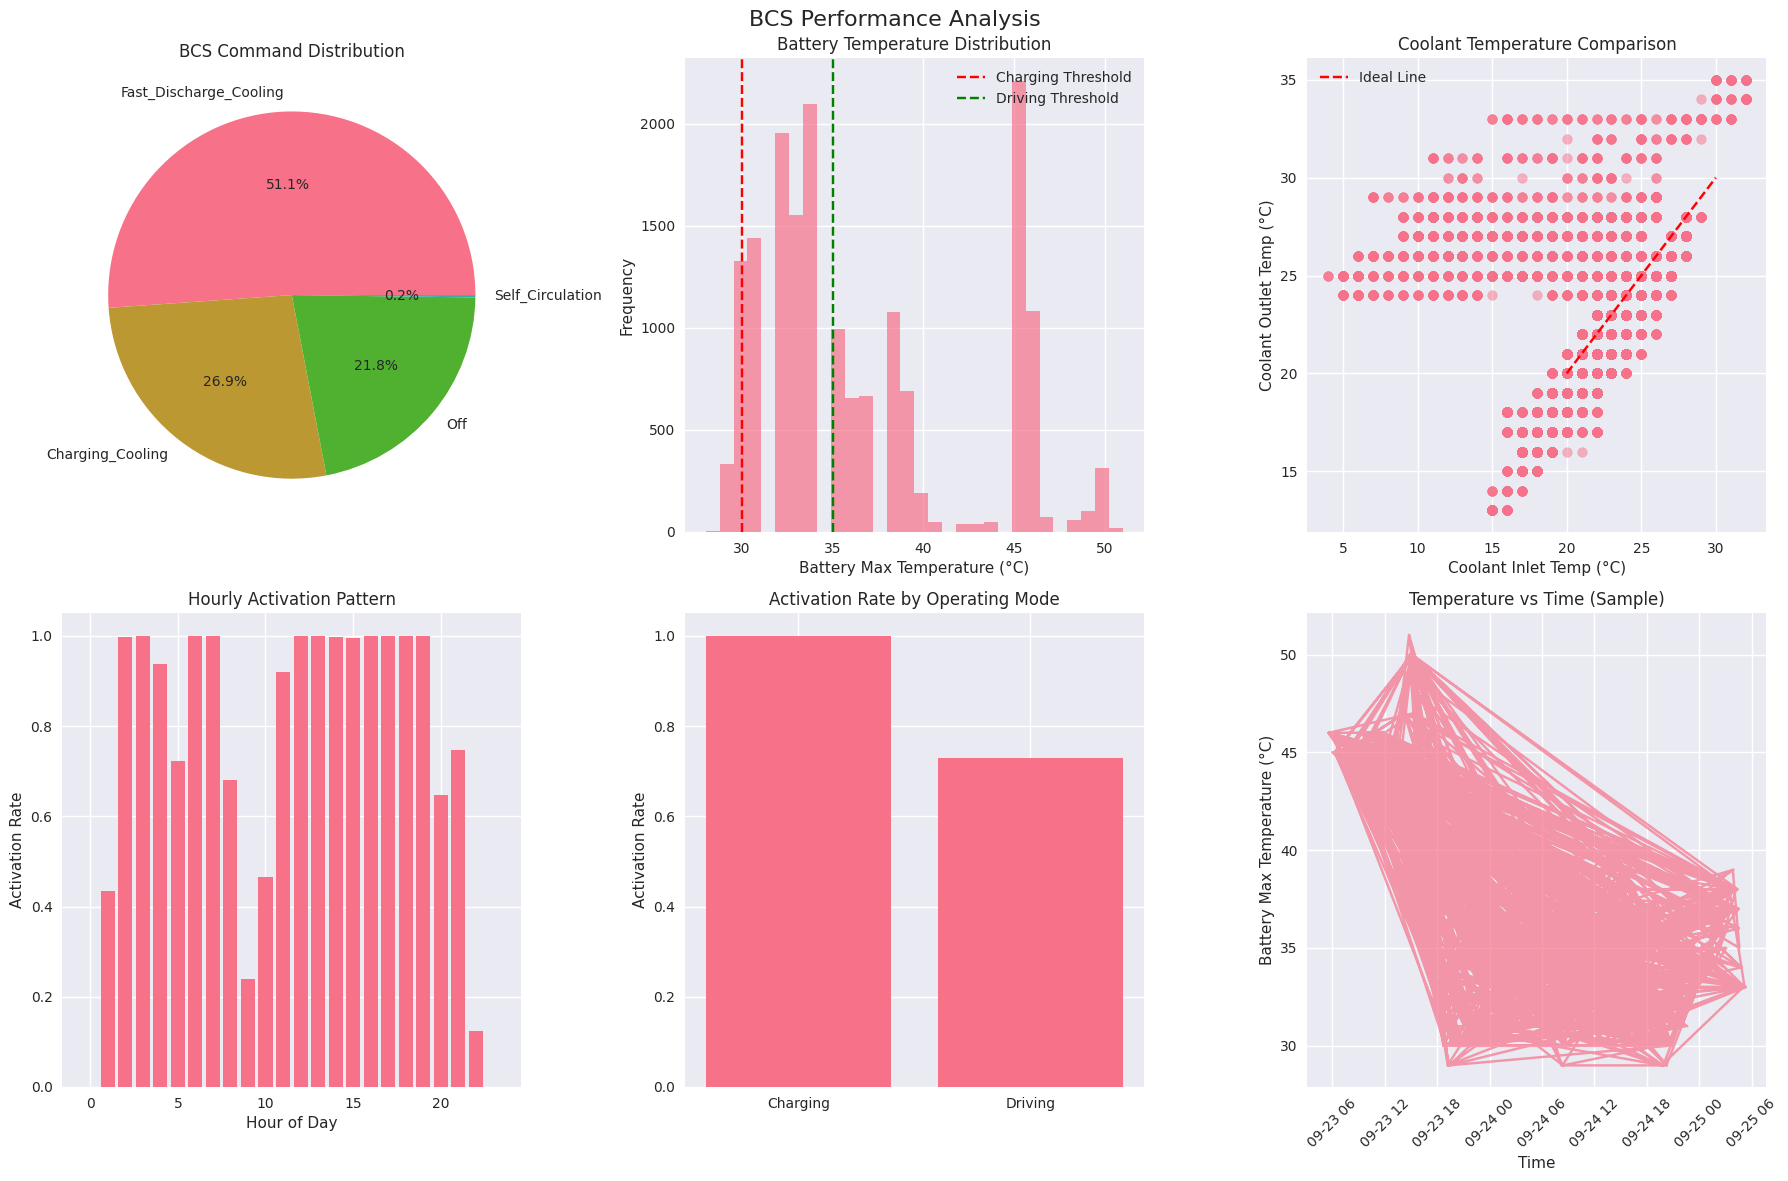

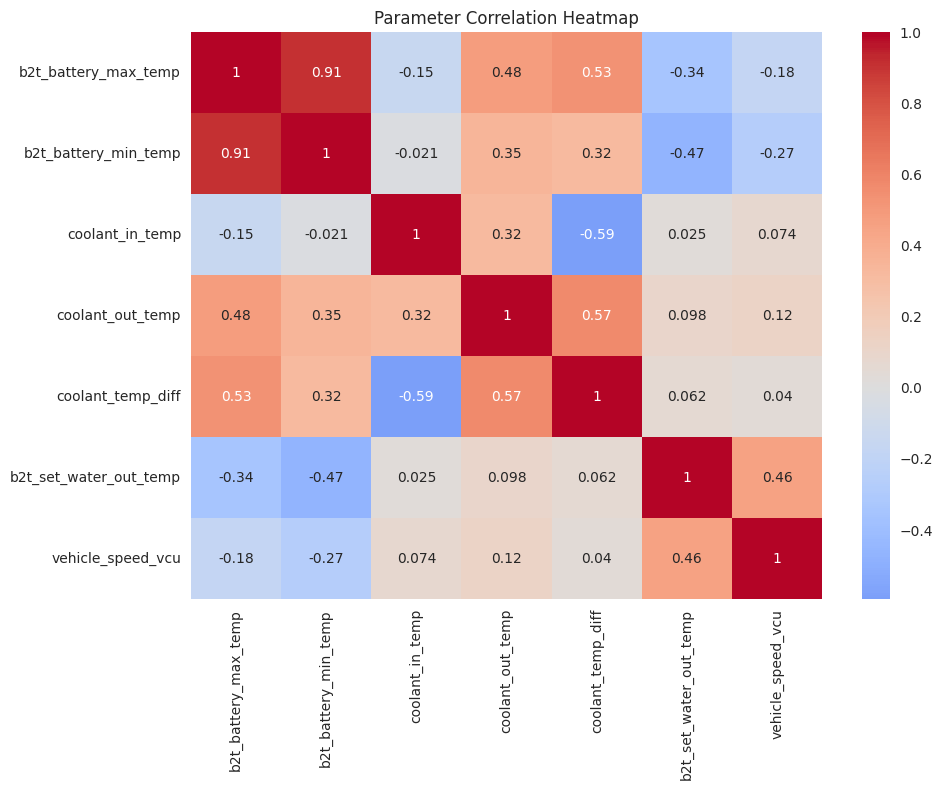

2025-10-24 07:26:13 - INFO - 
Visualizing Transition Data
2025-10-24 07:26:13 - INFO - ==================================================


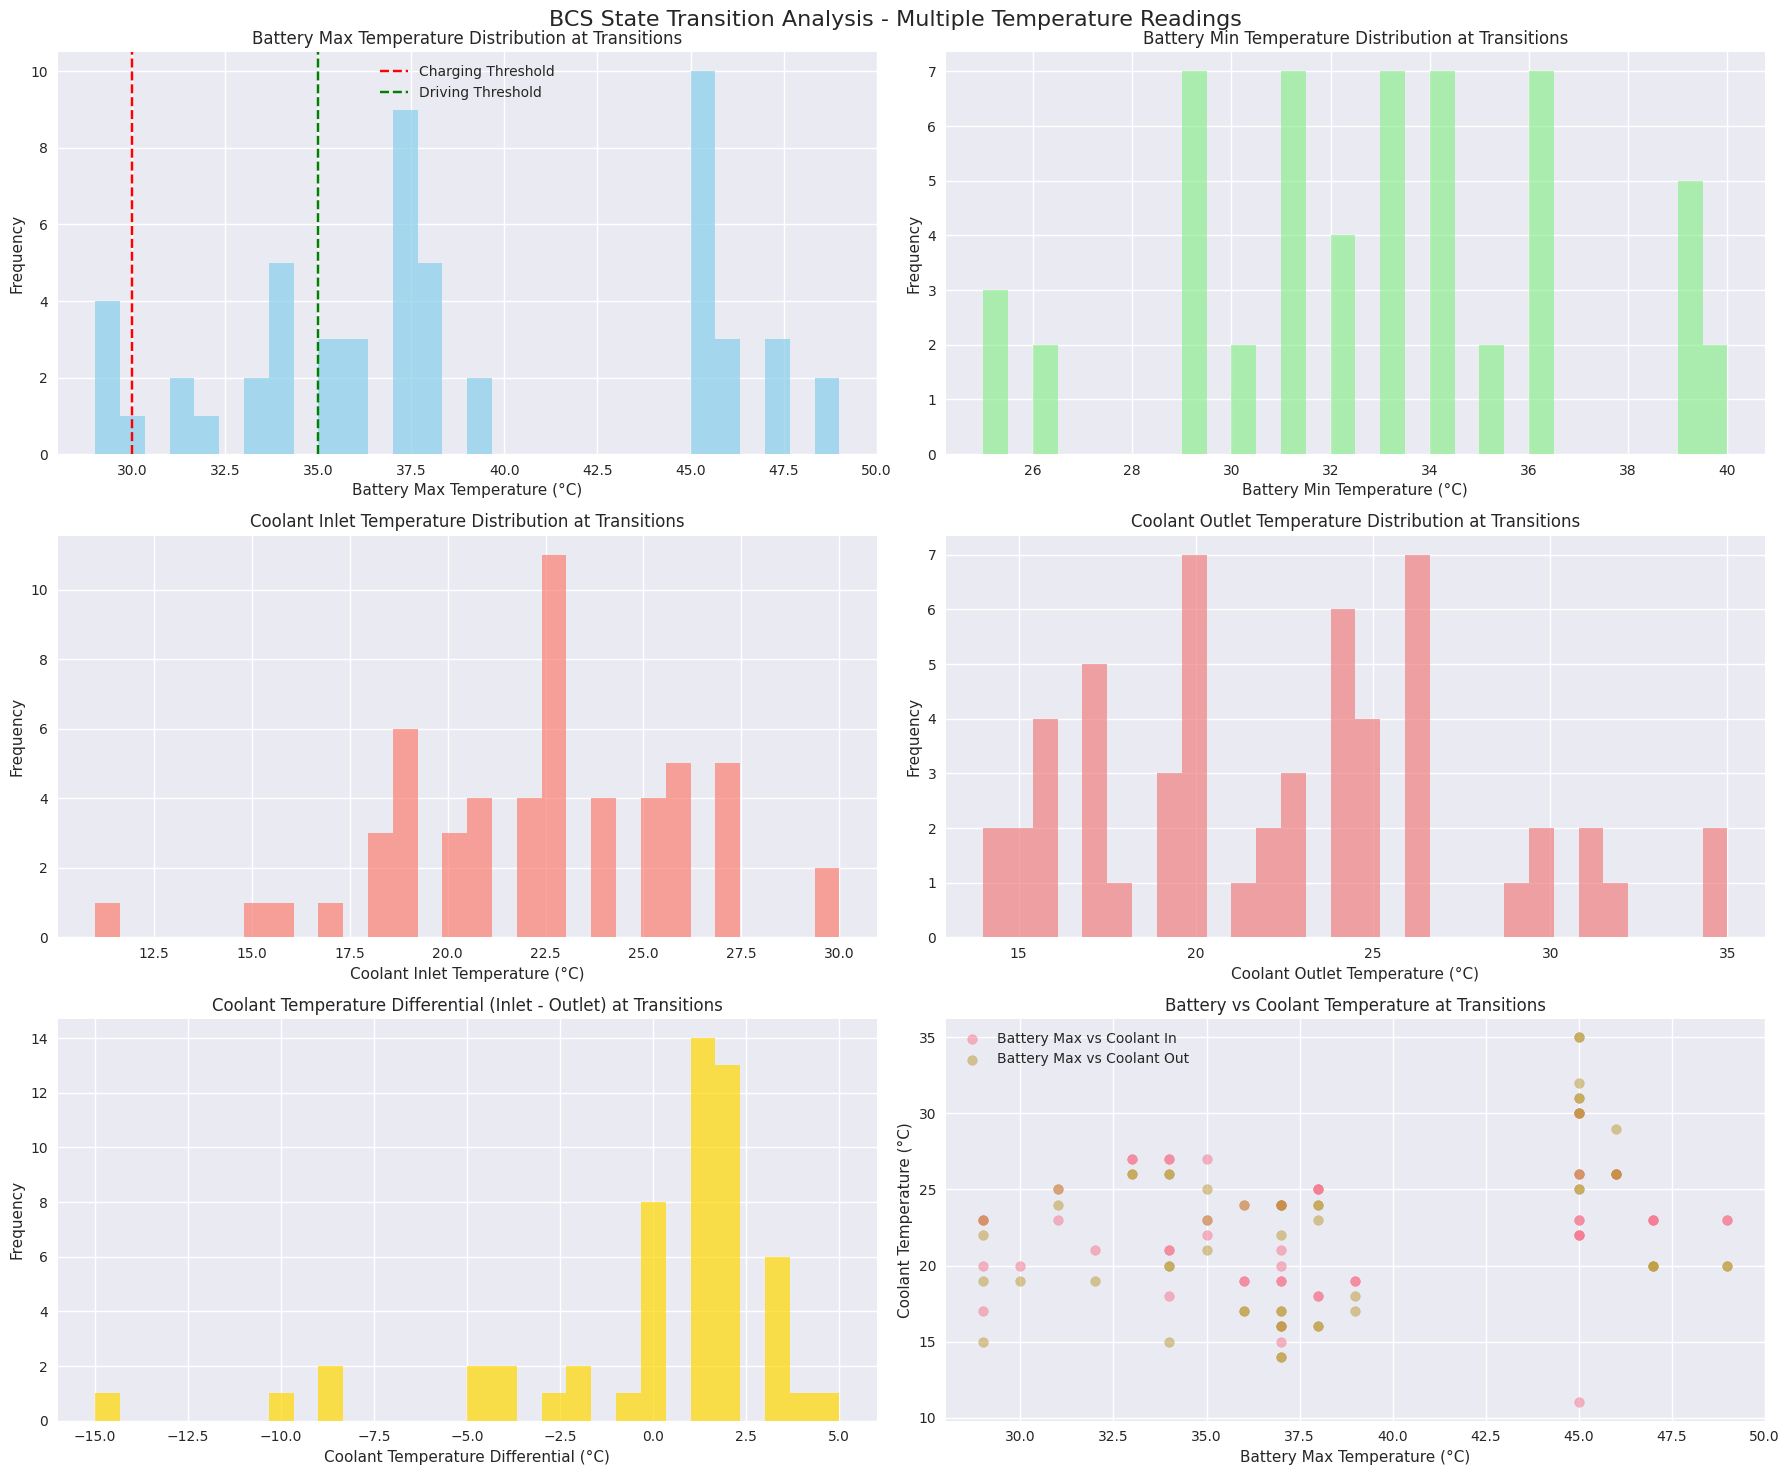

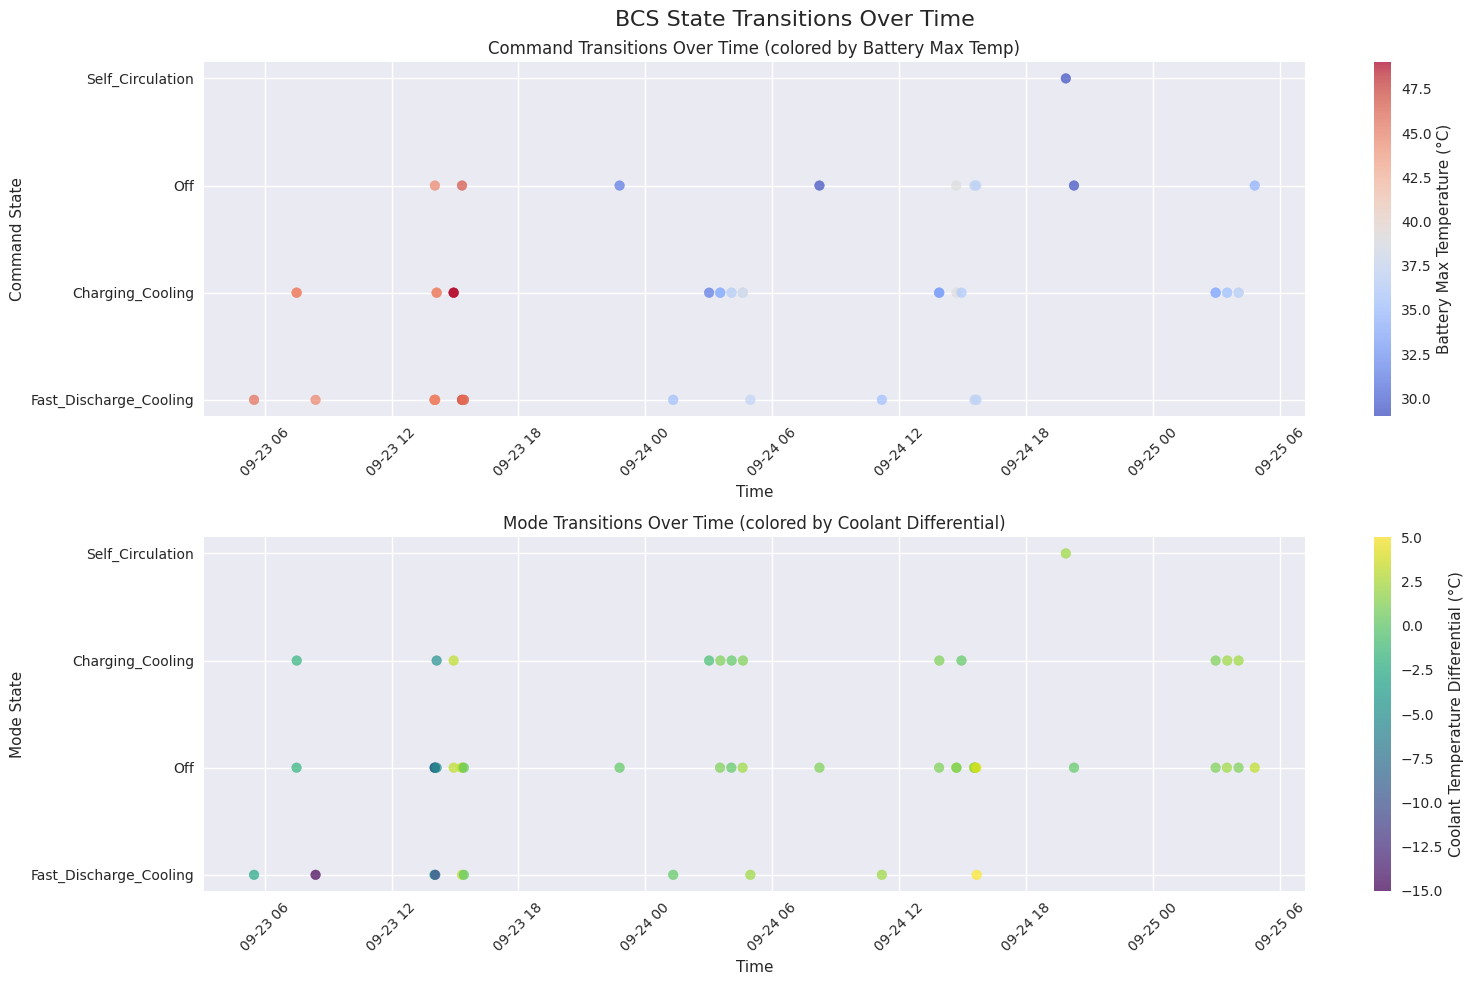

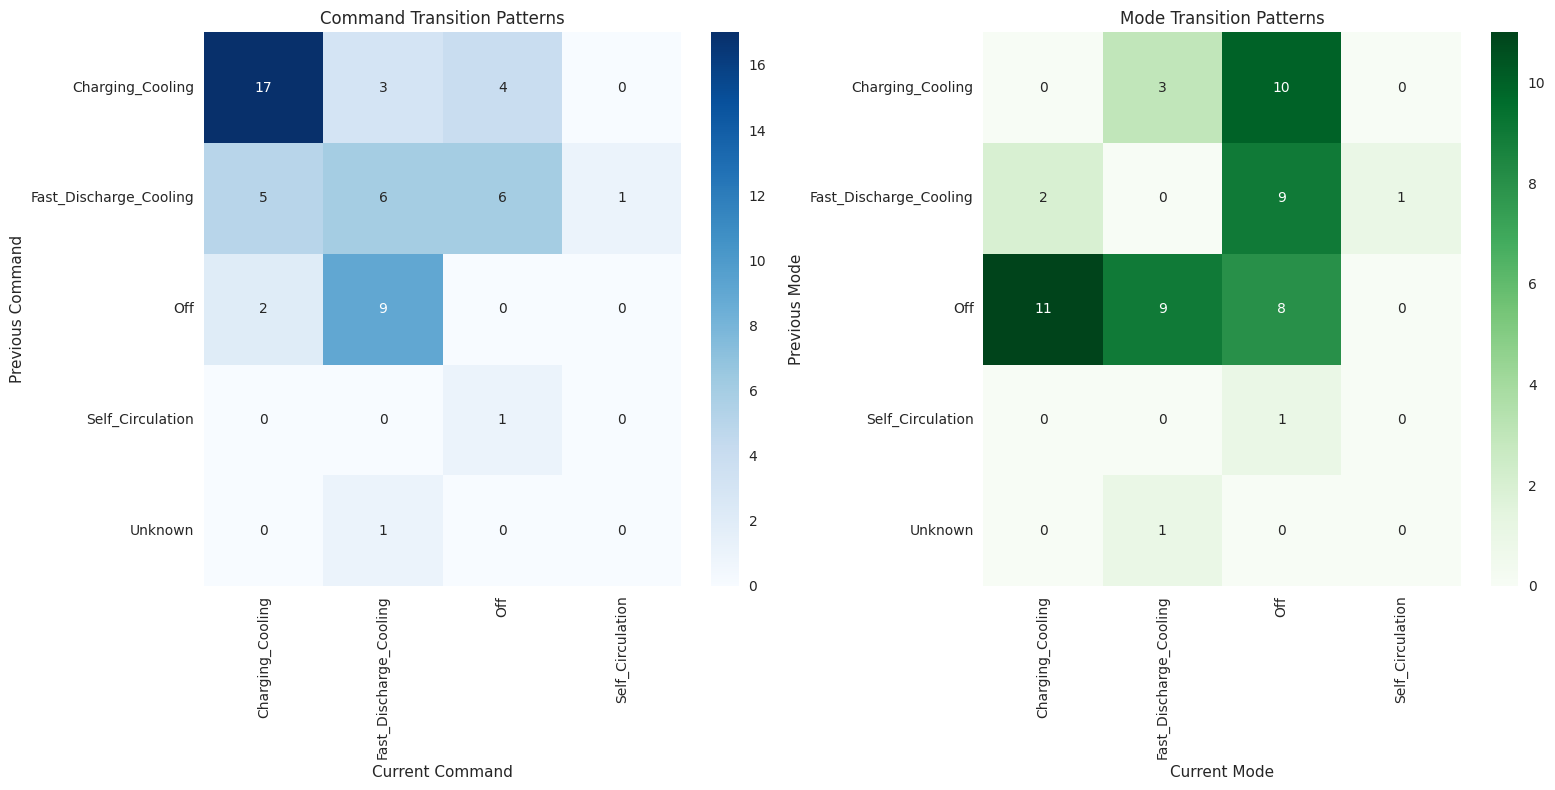

2025-10-24 07:26:14 - INFO - 
Step 11: Generating Recommendations
2025-10-24 07:26:14 - INFO - ==================================================
2025-10-24 07:26:14 - INFO - Recommendations:
2025-10-24 07:26:14 - INFO - 1. Charging activation temperature (38.0°C) is higher than expected (30°C). Consider reviewing control logic.
2025-10-24 07:26:14 - INFO - 2. Driving activation temperature (34.0°C) is lower than expected (35°C). System may be too sensitive during driving.
2025-10-24 07:26:14 - INFO - 3. Low setpoint achievement rate (0.0%). Cooling system is not reaching target temperatures.
2025-10-24 07:26:14 - INFO - 4. Low compressor activation rate (30.9%). Compressor may not be responding to cooling commands.
2025-10-24 07:26:14 - INFO - 
Analysis Complete!



Transition Data Sample:


,id,timestamp,prev_cmd,current_cmd,prev_mode,current_mode,battery_min_temp,battery_max_temp,coolant_in,coolant_out,transition_type,coolant_diff,hour
0,19,2025-09-23 05:30:02.383,Unknown,Fast_Discharge_Cooling,Unknown,Fast_Discharge_Cooling,35.0,46.0,26.0,29.0,both,-3.0,5.0
639,19,2025-09-23 07:30:29.945,Fast_Discharge_Cooling,Charging_Cooling,Fast_Discharge_Cooling,Off,33.0,45.0,23.0,25.0,both,-2.0,7.0
645,19,2025-09-23 07:31:03.665,Charging_Cooling,Charging_Cooling,Off,Charging_Cooling,33.0,45.0,23.0,25.0,mode_only,-2.0,7.0
1249,19,2025-09-23 08:24:30.835,Charging_Cooling,Fast_Discharge_Cooling,Charging_Cooling,Fast_Discharge_Cooling,34.0,45.0,11.0,26.0,both,-15.0,8.0
3151,19,2025-09-23 14:02:00.324,Fast_Discharge_Cooling,Fast_Discharge_Cooling,Fast_Discharge_Cooling,Off,36.0,45.0,26.0,30.0,mode_only,-4.0,14.0
3152,19,2025-09-23 14:02:01.484,Fast_Discharge_Cooling,Fast_Discharge_Cooling,Off,Fast_Discharge_Cooling,36.0,45.0,26.0,30.0,mode_only,-4.0,14.0
3153,19,2025-09-23 14:03:00.044,Fast_Discharge_Cooling,Off,Fast_Discharge_Cooling,Off,36.0,45.0,22.0,31.0,both,-9.0,14.0
3154,19,2025-09-23 14:03:01.264,Off,Fast_Discharge_Cooling,Off,Off,36.0,45.0,22.0,31.0,cmd_only,-9.0,14.0
3157,19,2025-09-23 14:04:05.664,Fast_Discharge_Cooling,Fast_Discharge_Cooling,Off,Fast_Discharge_Cooling,36.0,45.0,22.0,32.0,mode_only,-10.0,14.0
3169,19,2025-09-23 14:08:00.004,Fast_Discharge_Cooling,Charging_Cooling,Fast_Discharge_Cooling,Off,36.0,45.0,30.0,35.0,both,-5.0,14.0


In [17]:
# Define time range for analysis
start_time = '2025-09-23 00:00:00'
end_time = '2025-09-25 00:00:00'

# Define vehicle IDs (optional)
vehicle_ids = ['19']  # or ['3', '16', '18', '19']

# Run complete analysis
results, recommendations = run_full_analysis(
    start_time=start_time,
    end_time=end_time,
    vehicle_ids=vehicle_ids
)

# Access transition data
transition_df = results['transition_df']
print("\nTransition Data Sample:")
display(transition_df.head(10))

# # Access transition analysis
# transition_analysis = results['transition_analysis']
# print("\nBattery Max Temperature Statistics at Transitions:")
# print(transition_analysis['battery_max_temp_stats'])
# print("\nCoolant Temperature Statistics at Transitions:")
# print(transition_analysis['coolant_in_stats'])
# print(transition_analysis['coolant_out_stats'])
# print(transition_analysis['coolant_diff_stats'])